#Meeting Summarization Model Training

This is the process of training our summarizer model using Huggingface framework.

First check if GPU is available

In [ ]:
!nvidia-smi

Wed Feb 21 03:17:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Then pip install necessary libraries

In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 18.6 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade accelerate
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 4.4 MB/s eta 0:00:00
Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 19.2 MB/s eta 0:00:00
  Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)


Now let's import some modules.

In [ ]:
from transformers import pipeline, set_seed, AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset, load_from_disk, load_metric
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import torch
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Create a new variable called device so we can assign our model to device (in this case CUDA).

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

We will be using pegasus-x base model because it has maximum token length handling capacity of 16384, where we want to handle 4096 tokens length.

In [ ]:
model_ckpt="google/pegasus-x-base"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)
model=AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

Login to huggingface using your token.

In [ ]:
from huggingface_hub import login
login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Load the dataset.

In [ ]:
dataset = load_dataset("huuuyeah/meetingbank")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['summary', 'uid', 'id', 'transcript'],
        num_rows: 5169
    })
    validation: Dataset({
        features: ['summary', 'uid', 'id', 'transcript'],
        num_rows: 861
    })
    test: Dataset({
        features: ['summary', 'uid', 'id', 'transcript'],
        num_rows: 862
    })
})

Let's tokenize our dataset and see how the token length distribution is.

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['transcript'])

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'])

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [ ]:
dataset_converted=dataset.map(convert_examples_to_features, batched=True)

# Extract data from the dataset
train_data = dataset_converted['train']
validation_data = dataset_converted['validation']
test_data = dataset_converted['test']

# Convert to pandas DataFrame
train_df = pd.DataFrame(train_data)
validation_df = pd.DataFrame(validation_data)
test_df = pd.DataFrame(test_data)

train_df['input_token_length']=train_df['input_ids'].apply(lambda x: len(x))
train_df['output_token_length']=train_df['labels'].apply(lambda x: len(x))
validation_df['input_token_length']=validation_df['input_ids'].apply(lambda x: len(x))
validation_df['output_token_length']=validation_df['labels'].apply(lambda x: len(x))
test_df['input_token_length']=test_df['input_ids'].apply(lambda x: len(x))
test_df['output_token_length']=test_df['labels'].apply(lambda x: len(x))
train_df

Map:   0%|          | 0/5169 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (33373 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3866: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/861 [00:00<?, ? examples/s]

Map:   0%|          | 0/862 [00:00<?, ? examples/s]

,summary,uid,id,transcript,input_ids,attention_mask,labels,input_token_length,output_token_length
0,AS AMENDED a bill for an ordinance amending th...,DenverCityCouncil_05012017_17-0161,0,Please refrain from profane or obscene speech....,"[903, 17844, 135, 65820, 132, 36892, 3442, 107...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7569, 3887, 24426, 4137, 114, 2272, 118, 142,...",33373,205
1,AS AMENDED a bill for an ordinance amending th...,DenverCityCouncil_04102017_17-0161,1,An assessment has called out council bill 161 ...,"[983, 2843, 148, 568, 165, 4302, 2272, 38715, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7569, 3887, 24426, 4137, 114, 2272, 118, 142,...",3817,205
2,AS AMENDED a bill for an ordinance amending th...,DenverCityCouncil_02272017_17-0161,2,I Please close the voting. Announce the result...,"[125, 903, 686, 109, 6228, 107, 6549, 20595, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7569, 3887, 24426, 4137, 114, 2272, 118, 142,...",741,205
3,Recommendation to respectfully request City Co...,LongBeachCC_03072017_17-0161,3,"Motion passes. Hey, thank you very much. Now w...","[11904, 5182, 107, 10532, 108, 2041, 119, 221,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[44819, 112, 37488, 1320, 672, 1583, 3619, 113...",1189,22
4,AS AMENDED a bill for an ordinance amending th...,DenverCityCouncil_03202017_17-0161,4,All right. Pursuant to Council Bill 3.7 consid...,"[436, 268, 107, 881, 53884, 112, 1583, 3014, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7569, 3887, 24426, 4137, 114, 2272, 118, 142,...",6234,205
...,...,...,...,...,...,...,...,...,...
5164,AN ORDINANCE imposing a tax on engaging in the...,SeattleCityCouncil_06052017_CB 118965,5164,Thank you. The bill passed and chair of the Se...,"[1860, 119, 107, 139, 2272, 1973, 111, 2519, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[11232, 3915, 56044, 22368, 18378, 114, 1035, ...",7768,87
5165,Proclamation Declaring April 8 through April 1...,AlamedaCC_04022019_2019-6703,5165,Okay. Next is a proclamation declaring April e...,"[15320, 107, 3516, 117, 114, 32731, 21210, 960...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[74048, 110, 53715, 273, 960, 608, 224, 960, 8...",911,24
5166,Approves an agreement with Kaiser Foundation H...,DenverCityCouncil_01052015_14-1062,5166,I just pulled this one out. This one actually ...,"[125, 188, 4172, 136, 156, 165, 107, 182, 156,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[76843, 116, 142, 2158, 122, 25533, 2006, 1300...",795,124
5167,A bill for an Ordinance authorizing and approv...,DenverCityCouncil_06082015_15-0302,5167,The estimated taxable value following redevelo...,"[139, 3627, 21065, 564, 645, 21738, 117, 6680,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[202, 2272, 118, 142, 34633, 47429, 111, 29053...",12667,136


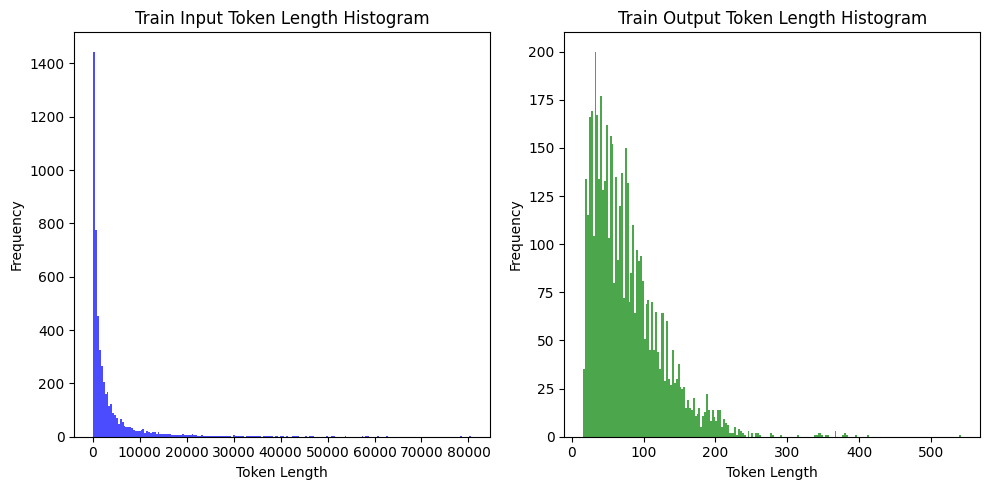

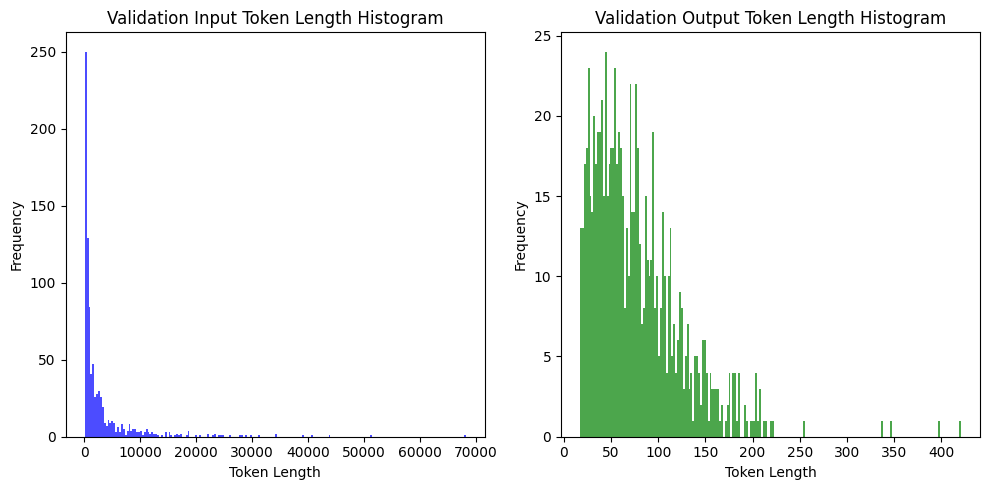

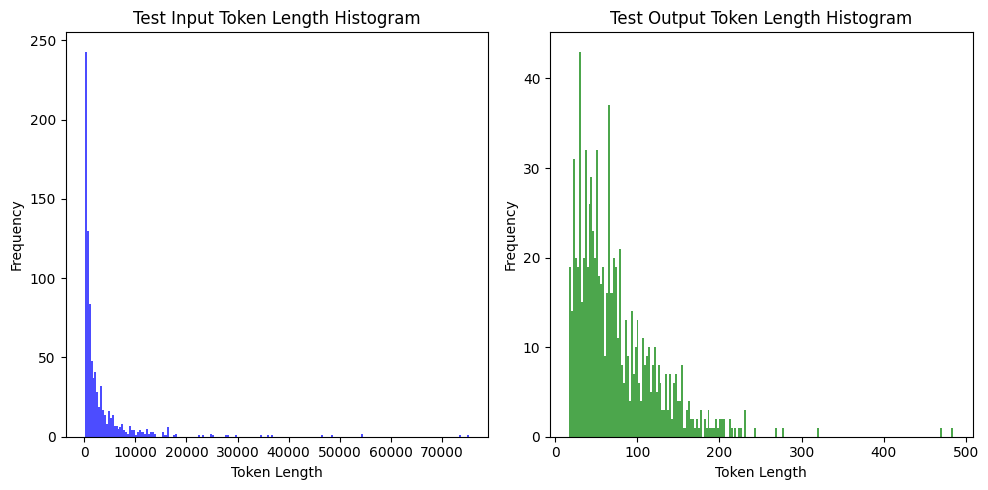

In [ ]:
import matplotlib.pyplot as plt

# Create histograms for train_df
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(train_df['input_token_length'], bins=200, color='blue', alpha=0.7)
plt.title('Train Input Token Length Histogram')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_df['output_token_length'], bins=200, color='green', alpha=0.7)
plt.title('Train Output Token Length Histogram')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create histograms for validation_df
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(validation_df['input_token_length'], bins=200, color='blue', alpha=0.7)
plt.title('Validation Input Token Length Histogram')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(validation_df['output_token_length'], bins=200, color='green', alpha=0.7)
plt.title('Validation Output Token Length Histogram')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create histograms for test_df
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(test_df['input_token_length'], bins=200, color='blue', alpha=0.7)
plt.title('Test Input Token Length Histogram')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_df['output_token_length'], bins=200, color='green', alpha=0.7)
plt.title('Test Output Token Length Histogram')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

As you can see, most of our entries fall below 10000 tokens. We only want to train our model on those entries with maximum length of 4096 tokens due to limitation of our GPU.

We will also be processing only 3000 entries among those entries with <4096 tokens, again due to our GPU quota limit.

In [ ]:
# Drop rows with input_token_length > 4096
train_df = train_df[train_df['input_token_length'] <= 4096]

# Drop rows with input_token_length > 4096
validation_df = validation_df[validation_df['input_token_length'] <= 4096]

# Drop rows with input_token_length > 4096
test_df = test_df[test_df['input_token_length'] <= 4096]

# Subset train_df to contain 3000 rows
train_df = train_df.head(3000)

# Subset validation_df to contain 400 rows
validation_df = validation_df.head(400)

# Subset test_df to contain 400 rows
test_df = test_df.head(400)

# Convert them back into dataset format
from datasets import DatasetDict, Dataset

train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

# Put them into DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

dataset

DatasetDict({
    train: Dataset({
        features: ['summary', 'uid', 'id', 'transcript', 'input_ids', 'attention_mask', 'labels', 'input_token_length', 'output_token_length', '__index_level_0__'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['summary', 'uid', 'id', 'transcript', 'input_ids', 'attention_mask', 'labels', 'input_token_length', 'output_token_length', '__index_level_0__'],
        num_rows: 400
    })
    test: Dataset({
        features: ['summary', 'uid', 'id', 'transcript', 'input_ids', 'attention_mask', 'labels', 'input_token_length', 'output_token_length', '__index_level_0__'],
        num_rows: 400
    })
})

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['transcript'] , max_length = 4096, truncation = True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 600, truncation = True)

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [ ]:
dataset_converted=dataset.map(convert_examples_to_features, batched=True, remove_columns=['id', 'uid', 'transcript','summary','input_token_length', 'output_token_length','__index_level_0__'])

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3866: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
dataset_converted

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 400
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 400
    })
})

In [ ]:
# Extract data from the dataset
train_data = dataset_converted['train']
validation_data = dataset_converted['validation']
test_data = dataset_converted['test']

# Convert to pandas DataFrame
train_df = pd.DataFrame(train_data)
validation_df = pd.DataFrame(validation_data)
test_df = pd.DataFrame(test_data)

train_df['input_token_length']=train_df['input_ids'].apply(lambda x: len(x))
train_df['output_token_length']=train_df['labels'].apply(lambda x: len(x))
validation_df['input_token_length']=validation_df['input_ids'].apply(lambda x: len(x))
validation_df['output_token_length']=validation_df['labels'].apply(lambda x: len(x))
test_df['input_token_length']=test_df['input_ids'].apply(lambda x: len(x))
test_df['output_token_length']=test_df['labels'].apply(lambda x: len(x))
train_df.head()

,input_ids,attention_mask,labels,input_token_length,output_token_length
0,"[983, 2843, 148, 568, 165, 4302, 2272, 38715, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7569, 3887, 24426, 4137, 114, 2272, 118, 142,...",3817,205
1,"[125, 903, 686, 109, 6228, 107, 6549, 20595, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7569, 3887, 24426, 4137, 114, 2272, 118, 142,...",741,205
2,"[11904, 5182, 107, 10532, 108, 2041, 119, 221,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[44819, 112, 37488, 1320, 672, 1583, 3619, 113...",1189,22
3,"[1073, 20157, 108, 11469, 20517, 148, 174, 481...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7569, 3887, 24426, 4137, 114, 2272, 118, 142,...",1512,205
4,"[1583, 117, 90483, 107, 184, 133, 156, 976, 24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7569, 3887, 24426, 4137, 114, 2272, 118, 142,...",203,205


Now let's import our data collator.

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator= DataCollatorForSeq2Seq(tokenizer, model=model)

And then create our trainer object. We will be using high learning rate of 0.0001, but with 'reduce_lr_on_plateau' argument so it will 'brake' our learning rate in case our validation loss doesn't improve. This will help us achieve more accurate summarization.

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args=TrainingArguments(
    output_dir='pegasus_x-meeting-summarizer', num_train_epochs=3, learning_rate=0.0001, lr_scheduler_type="reduce_lr_on_plateau",
    metric_for_best_model='eval_loss', greater_is_better=False,
    per_device_train_batch_size=1,per_device_eval_batch_size=1,weight_decay=0.01,logging_steps=10,
    evaluation_strategy='steps',save_steps=1e6,gradient_accumulation_steps=16
)

trainer=Trainer(model=model, args=trainer_args,tokenizer=tokenizer,data_collator=seq2seq_data_collator,
                train_dataset=dataset_converted['train'],eval_dataset=dataset_converted['validation'])

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
10,4.046100,2.661134
20,2.865600,2.331347
30,2.512200,2.150239
40,2.394100,2.007111
50,2.244500,1.911042
60,2.205000,1.838750
70,2.134100,1.772791
80,1.979300,1.746401
90,1.861600,1.692965
100,1.884800,1.658896


TrainOutput(global_step=561, training_loss=1.6093911793142717, metrics={'train_runtime': 7791.6978, 'train_samples_per_second': 1.155, 'train_steps_per_second': 0.072, 'total_flos': 1.2923518696998912e+16, 'train_loss': 1.6093911793142717, 'epoch': 2.99})

Seems like our model is doing good, with traing loss and validation loss at aroud the same value which means it doesn't overfit. Let's save our model beforehand.

In [ ]:
# Upload the model to the Hub
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 16384, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


model.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1708455121.7d984f560b48.508.0:   0%|          | 0.00/29.5k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aruca/pegasus_x-meeting-summarizer/commit/764e7ffabbdf882caad57a39746a27a97d69a34f', commit_message='End of training', commit_description='', oid='764e7ffabbdf882caad57a39746a27a97d69a34f', pr_url=None, pr_revision=None, pr_num=None)

And then evaluate our model.

In [ ]:
# Compute the evaluation metrics
trainer.evaluate()

{'eval_loss': 1.2445331811904907,
 'eval_runtime': 56.9398,
 'eval_samples_per_second': 7.025,
 'eval_steps_per_second': 7.025,
 'epoch': 2.99}

Let's redefine our model using the model we just saved to our huggingface hub.

In [ ]:
from transformers import pipeline

# Load your model and tokenizer
model_name = "aruca/pegasus_x-meeting-summarizer"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define your pipeline for inference
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

Let's redefine our dataset again, this time without removing transcript and summary column.

In [ ]:
dataset_converted=dataset.map(convert_examples_to_features, batched=True, remove_columns=['id', 'uid','input_token_length', 'output_token_length','__index_level_0__'])

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3866: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Let's test our model on one of sample article.

In [ ]:
from rouge_score import rouge_scorer

article="""Agenda Item 38 Council Bill 118484 relating to the Cedar River watershed authorizing five years of ecological thinning in accordance with the Cedar River Watershed Habitat Conservation Plan and sections 15, 16, 21 and 22. Township 22, North Range seven, East W.M. Sections eight and nine, township 22, North Range eight, East W M Sections two and 11. Township 21, North Range nine East W.M. Sections 34 and 35. Township 22, North Range nine East W.M. Sections three, four and ten. Township 21, North Range ten, East W.M. and sections 32 and 33. Township 22, North Range ten East W m declaring the logs resulting from the ecological thinning to be surplus to the city's needs, authorizing the sale of such logs pursuant to applicable city contracting and surplus property sale procedures and directing deposit of the proceeds therefrom to the Water Fund. For the purposes of the Habitat Conservation Plan implementation, the committee recommends a Council bill pass. Thank you, Councilmember Bagshaw. Thank you. This ordinance will authorize Seattle Public Utilities to enter into a contract for five years of forest thinning projects. And these do have ecological benefits in our Cedar River habitat as part of the conservation plan. It authorizes the sale of surplus logs that result from the ecological thinning. I actually went out and looked at the site. The thinning activities are really small in comparison to what I think some people were concerned about. We're not going in and taking out old growth. It ultimately helps us with the water quality and the timber revenues are not that significant. They thin the the the forest generally with some things that are smaller in size, but then it'll result in about $40,000, which will be deposited in the water fund to offset the costs of implementing the plan. The design is to improve forest health. It also will decrease forest fires possibilities and it is consistent with our habitat management practice and we recommend approval. Thank you. Questions or comments? This is item 38, correct? Correct. Please call the rule on the passage of the bill. Harrell I look at it. I o'brien. I, okamoto. Rasmussen I so want I shot. I. Got in I am president Burgess high nine and favorite on the post. The bill passes and the chair will sign it. Please read item 39 to the first semicolon.
"""

summary="""AN ORDINANCE relating to the Cedar River Watershed; authorizing five years of ecological thinning, in accordance with the Cedar River Watershed Habitat Conservation Plan, in Sections 15, 16, 21 and 22, Township 22, North, Range 7, East, W.M., Sections 8 and 9, Township 22, North, Range 8, East, W.M., Sections 2 and 11, Township 21, North, Range 9, East, W.M.; Sections 34 and 35, Township 22, North, Range 9, East, W.M., Sections 3, 4 and 10, Township 21, North, Range 10, East, W.M., and Sections 32 and 33, Township 22, North, Range 10, East, W.M.; declaring the logs resulting from ecological thinning to be surplus to the City’s needs; authorizing the sale of such logs pursuant to applicable City contracting and surplus property sale procedures; and directing deposit of the proceeds therefrom to the Water Fund for the purposes of the Habitat Conservation Plan implementation."""
prediction=summarizer(article, max_length=4096, do_sample=False)[0]['summary_text']

# Calculate ROUGE 1, ROUGE 2, and ROUGE L score
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(summary, prediction)

# Calculate ROUGE-LSUM score
summary_length = len(summary.split())
prediction_length = len(prediction.split())
rouge_lsum_score = min(1, prediction_length / summary_length)

# Print ROUGE scores
print("ROUGE-1 F1 Score:", scores['rouge1'].fmeasure)
print("ROUGE-2 F1 Score:", scores['rouge2'].fmeasure)
print("ROUGE-L F1 Score:", scores['rougeL'].fmeasure)
print("ROUGE-LSUM Score:", rouge_lsum_score)

Your max_length is set to 4096, but your input_length is only 468. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=234)


ROUGE-1 F1 Score: 0.6181818181818182
ROUGE-2 F1 Score: 0.5779816513761469
ROUGE-L F1 Score: 0.609090909090909
ROUGE-LSUM Score: 0.46206896551724136


It's doing not bad as you can see from the ROUGE scores above.

You can see the comparison between the supposed summary and our prediction below. Apparently our prediction, while managed to capture all the context, is still unable to make detailed summary such as including the precise sections name. This is to be expected since both our training loss and validation loss resides in around 1.2, which means that our model is a generalist model.

In [ ]:
summary

'AN ORDINANCE relating to the Cedar River Watershed; authorizing five years of ecological thinning, in accordance with the Cedar River Watershed Habitat Conservation Plan, in Sections 15, 16, 21 and 22, Township 22, North, Range 7, East, W.M., Sections 8 and 9, Township 22, North, Range 8, East, W.M., Sections 2 and 11, Township 21, North, Range 9, East, W.M.; Sections 34 and 35, Township 22, North, Range 9, East, W.M., Sections 3, 4 and 10, Township 21, North, Range 10, East, W.M., and Sections 32 and 33, Township 22, North, Range 10, East, W.M.; declaring the logs resulting from ecological thinning to be surplus to the City’s needs; authorizing the sale of such logs pursuant to applicable City contracting and surplus property sale procedures; and directing deposit of the proceeds therefrom to the Water Fund for the purposes of the Habitat Conservation Plan implementation.'

In [ ]:
prediction

'AN ORDINANCE relating to the Cedar River watershed; authorizing five years of ecological thinning in accordance with the Cedar River Watershed Habitat Conservation Plan; and declaring the logs resulting from the ecological thinning to be surplus to the City’s needs, authorizing the sale of such logs pursuant to applicable City contracting and surplus property sale procedures, and directing deposit of the proceeds therefrom to the Water Fund.'

For testing, let's test our model on 10 entries of our test dataset. Why only 10? Because of the GPU/CPU limitation which I have tested, caused our testing to get stuck on the eleventh entry.

In [ ]:
from rouge_score import rouge_scorer
from tqdm.auto import tqdm

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Initialize lists to store ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
rougeLSUM_scores = []

# Iterate over the first 10 examples in the test dataset
for idx, (summary, transcript) in tqdm(enumerate(zip(dataset_converted['test']['summary'][:10], dataset_converted['test']['transcript'][:10])), total=10):
    # Generate summary for the example using your model
    prediction = summarizer(transcript, max_length=4096, do_sample=False)[0]['summary_text']

    # Calculate ROUGE scores
    scores = scorer.score(summary, prediction)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate ROUGE-LSUM score
    summary_length = len(summary.split())
    prediction_length = len(prediction.split())
    rouge_lsum_score = min(1, prediction_length / summary_length)
    rougeLSUM_scores.append(rouge_lsum_score)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
avg_rougeLSUM = sum(rougeLSUM_scores) / len(rougeLSUM_scores)

# Print average ROUGE scores
print("Average ROUGE-1 F1 Score:", avg_rouge1)
print("Average ROUGE-2 F1 Score:", avg_rouge2)
print("Average ROUGE-L F1 Score:", avg_rougeL)
print("Average ROUGE-LSUM Score:", avg_rougeLSUM)

  0%|          | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1333 > 1024). Running this sequence through the model will result in indexing errors
Your max_length is set to 4096, but your input_length is only 1333. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=666)
Your max_length is set to 4096, but your input_length is only 584. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=292)
Your max_length is set to 4096, but your input_length is only 316. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=158)
Your max_length is set to 4096, but your input_length is on

Average ROUGE-1 F1 Score: 0.6443630187820435
Average ROUGE-2 F1 Score: 0.5695029003181815
Average ROUGE-L F1 Score: 0.6315452991015787
Average ROUGE-LSUM Score: 0.7549443092873689


And those are our ROUGE scores which is fairly good. I think it's good enough to bring our model for deployment.